# Synthetic Clear Sky

In this notebook, we generate a synthetic power signal for a system located in souther California. We make use of the `pvlib-python` PV modeling package. The goal is to compare the solar eigenvectors generated by this method to the eigenvectors generated from real data.

In [2]:
from clearsky.main import StatisticalClearSky
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')

Load the Sandia module and CEC inverter databases.

In [3]:
# load some module and inverter specifications
sandia_modules = retrieve_sam('SandiaMod')
cec_inverters = retrieve_sam('cecinverter')

sandia_module = sandia_modules['SunPower_SP305_GEN_C_Module__2008__E__']
cec_inverter = cec_inverters['SMA_America__SB3000US_240V__CEC_2007_']

Set up the system and location  model chain.

In [4]:
location = Location(latitude=33.68, longitude=-117.82, altitude=60, tz='America/Los_Angeles')
system = PVSystem(surface_tilt=20, surface_azimuth=200,
                  module_parameters=sandia_module,
                  inverter_parameters=cec_inverter)
mc = ModelChain(system, location)

Create the time index for the simulated data. Because the statistical clear sky fitting algorithm requires at least one year of data, we simulate 13 months.

In [6]:
times = pd.DatetimeIndex(start='2016-01-01', end='2017-02-01', freq='5min', tz=location.tz)

In [7]:
mc.run_model(times=times, weather=None)

/Users/bennetmeyers/.virtualenvs/clearsky/lib/python2.7/site-packages/pvlib/pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
/Users/bennetmeyers/.virtualenvs/clearsky/lib/python2.7/site-packages/pvlib/pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +


ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses

Below we inspect a single day in the simulated data set.

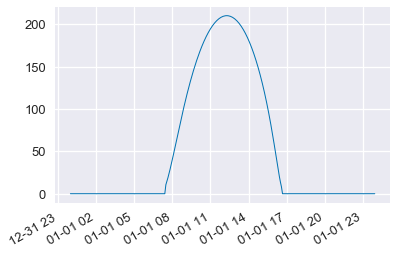

In [8]:
mc.ac.loc['2016-01-01':'2016-01-01'].plot(linewidth=1)

The morning and evening behavior is concerning in the context of analyzing the time-series structure of this data. From a total energy standpoint, this simulation is adequate, but the shart corners at sunrise and sunset do not represent the real behavior of systems, which behave more smoothly, due to diffuse components of irradiance and non-ideal horizons. Any orthonormal decomposition of this signal will have difficulty with non-physical, sharp transitions (think of the Fourier series representation of a square wave), so we smooth out these transitions by controlling the 2nd derivative of a signal fitted to the observed signal, as shown below.

In [9]:
import cvxpy as cvx

In [10]:
s_ac = cvx.Variable(len(mc.ac.iloc[:-1]))
mu = cvx.Parameter(sign='positive', value=10**(1.5))
cost = cvx.norm(mc.ac.iloc[:-1].as_matrix() - s_ac) + mu * cvx.norm2(s_ac[2:] - 2 * s_ac[1:-1] + s_ac[:-2])
constraints = [
    s_ac >= 0
]
problem = cvx.Problem(objective=cvx.Minimize(cost), constraints=constraints)
problem.solve(solver='MOSEK')

2002.8953222653834

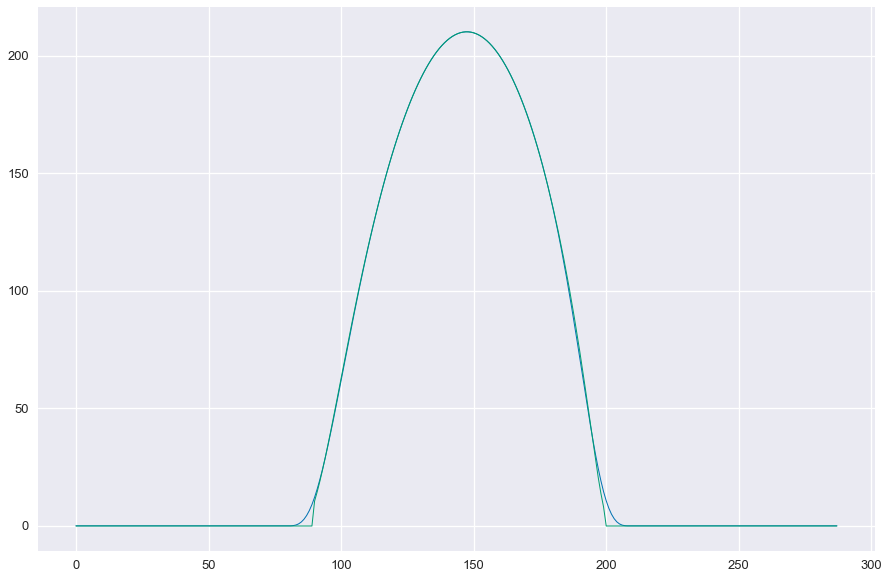

In [11]:
fig = plt.figure(figsize=(15, 10))
plt.plot(s_ac.value.A1[:288], linewidth=1)
plt.plot(mc.ac.iloc[:288].as_matrix(), linewidth=1)

In [12]:
scs = StatisticalClearSky(pd.Series(data=s_ac.value.A1, index=mc.ac.iloc[:-1].index))

In [13]:
scs.get_eigenvectors()

<Container object of 3 artists>

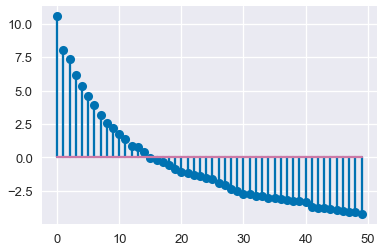

In [14]:
plt.stem(np.log(scs.D[:50]))

Text(0.5,0,u'Vector Index')

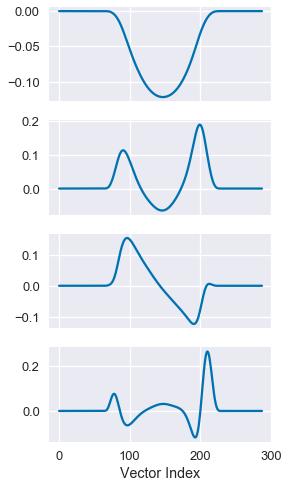

In [20]:
N=4
fig, axes = plt.subplots(nrows=N, figsize=(4,8), sharex=True)
for i in xrange(N):
    axes[i].plot(scs.U[:, i])
plt.xlabel('Vector Index')

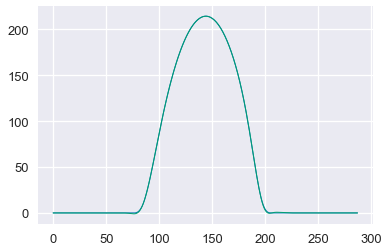

In [16]:
scs.reconstruct_day(day=327, n=5)

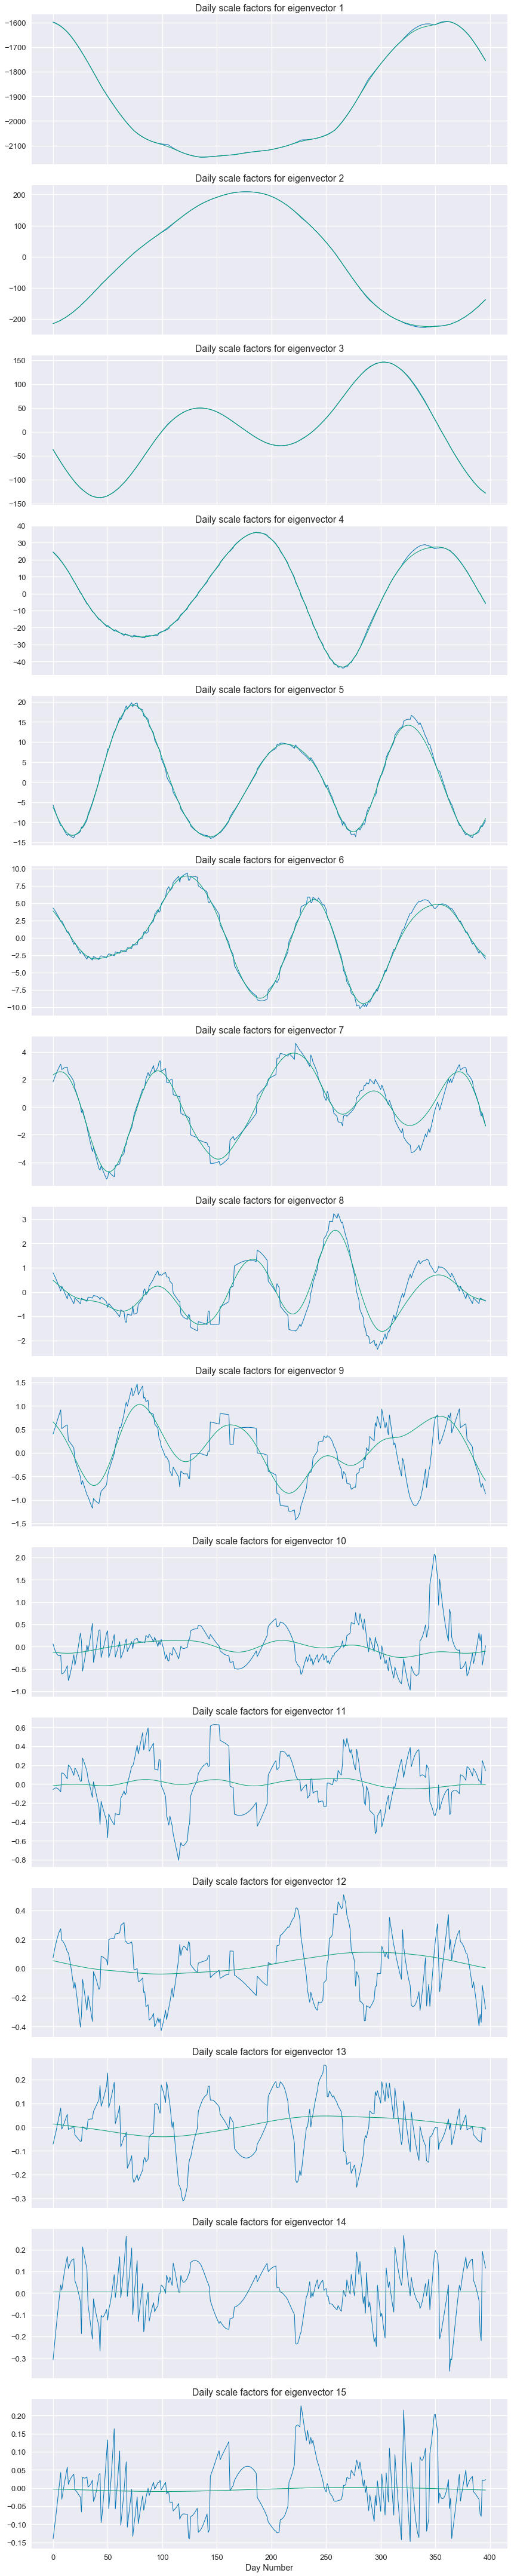

In [17]:
_ = scs.make_clearsky_model(n=15, plot=True)